In [1]:
import mph
import numpy as np
from scipy.optimize import minimize, differential_evolution
import matplotlib.pyplot as plt
import pandas as pd
import time

ION Q TRAP OPTIMIZATION
Starting COMSOL client...
Loading COMSOL model...
Optimization Parameters:
  rod_radius     : 2.0 (range: 0.5 to 3.0)
  rod_spacing    : 5.0 (range: 2.0 to 8.0)
  V_rf           : 300 (range: 100 to 500)
  V_dc           : 50 (range: 10 to 100)
  endcap_offset  : 1.0 (range: 0.5 to 3.0)
  V_endcap       : 10 (range: 5 to 30)
  f              : 10 (range: 5 to 20)

Starting optimization...

PHASE 1: Local Optimization (Nelder-Mead)
Testing parameters: [  2.   5. 300.  50.   1.  10.  10.]
Results - Depth: 0.117eV, Offset: 10.000mm, Power: 8797.3mW
Objective: 248.599 (base: 47.653, penalty: 200.946)
------------------------------------------------------------
Testing parameters: [  2.1   5.  300.   50.    1.   10.   10. ]
Results - Depth: 0.074eV, Offset: 10.000mm, Power: 8797.3mW
Objective: 248.577 (base: 47.631, penalty: 200.946)
------------------------------------------------------------
Testing parameters: [  2.     5.25 300.    50.     1.    10.    10.  ]
Res

/tmp/ipykernel_233199/2755445497.py:172: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(


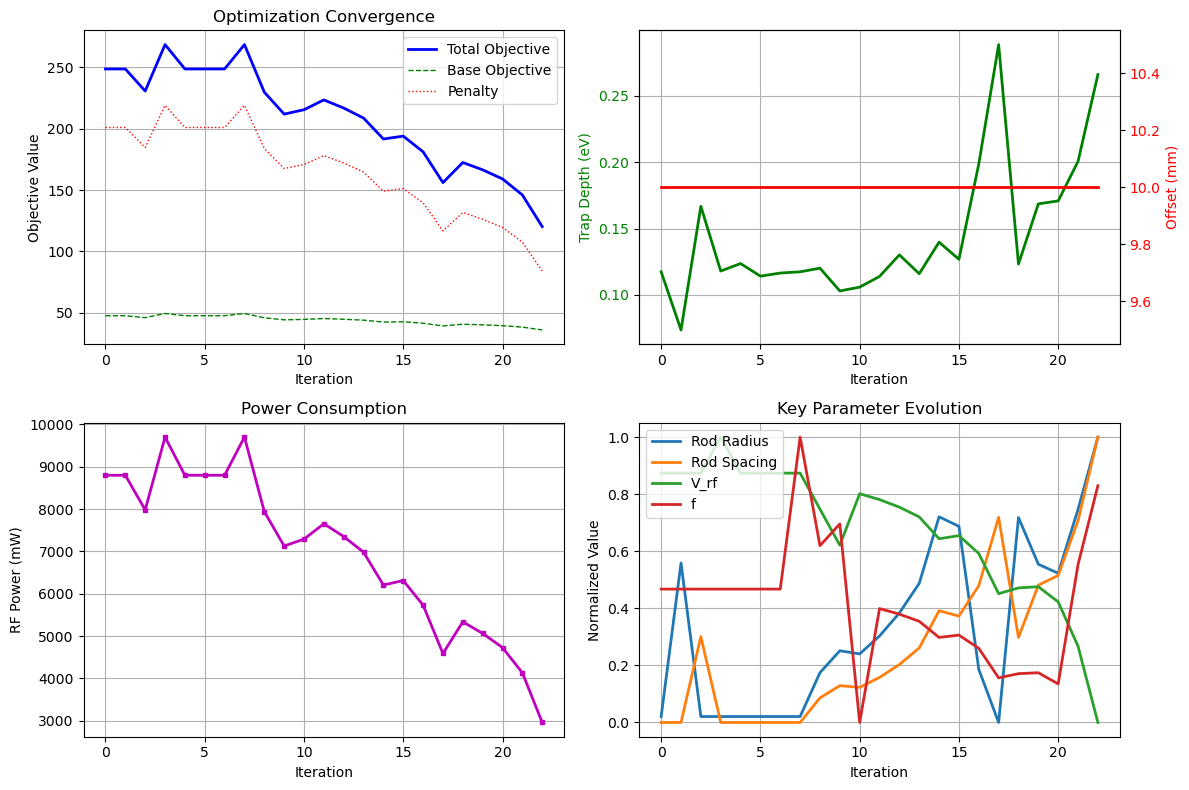

Optimization report saved to ionq_optimization_report.txt

OPTIMIZATION COMPLETED SUCCESSFULLY!
Total iterations: 23
Failed simulations: 0
Best trap depth: 0.2660 eV
Best offset: 10.0000 mm
Best power: 2957.63 mW

Cleaning up COMSOL client...
Done!


In [2]:
import mph
import numpy as np
from scipy.optimize import minimize, differential_evolution
import matplotlib.pyplot as plt
import pandas as pd
import time

class IonQTrapOptimizer:
    def __init__(self, model_path):
        print("Starting COMSOL client...")
        self.client = mph.start(cores=1)
        print("Loading COMSOL model...")
        self.model = self.client.load(model_path)
        self.optimization_history = []
        self.failed_simulations = 0
        self.max_failures = 5
        
    def safe_simulation(self, params):
        """Run simulation with error handling for multiphysics compilation"""
        try:
            # Update parameters
            self.update_parameters(params)
            
            # Solve the model with timeout
            self.model.solve()
            
            # Extract metrics
            metrics = self.extract_trap_metrics()
            if metrics is None:
                raise ValueError("Failed to extract metrics")
                
            self.failed_simulations = 0  # Reset failure counter on success
            return metrics
            
        except Exception as e:
            self.failed_simulations += 1
            print(f"Simulation failed: {e}")
            
            if self.failed_simulations >= self.max_failures:
                raise RuntimeError(f"Too many consecutive failures ({self.max_failures}). Stopping optimization.")
            
            # Return conservative default values that encourage exploration away from problematic parameters
            return {
                'depth_eV': 0.001,  # Very bad depth
                'offset_mm': 10.0,  # Large offset
                'P_est_mW': 1000.0, # High power
                'minU_eV': 0.0,
                'maxU_eV': 0.0,
                'trap_x': 0.0,
                'trap_y': 0.0, 
                'trap_z': 0.0
            }
    
    def extract_trap_metrics(self):
        """Extract all trap metrics from COMSOL results"""
        try:
            metrics = {
                'depth_eV': float(self.model.evaluate('depth_eV')),
                'minU_eV': float(self.model.evaluate('minU_eV')),
                'maxU_eV': float(self.model.evaluate('maxU_eV')),
                'trap_x': float(self.model.evaluate('trap_x')),
                'trap_y': float(self.model.evaluate('trap_y')), 
                'trap_z': float(self.model.evaluate('trap_z')),
                'offset_mm': float(self.model.evaluate('offset_mm')),
                'P_est_mW': float(self.model.evaluate('P_est_mW'))
            }
            return metrics
        except Exception as e:
            print(f"Error extracting metrics: {e}")
            return None
    
    def objective_function(self, params):
        """
        Main objective function to minimize
        We want to minimize depth_eV, offset_mm, and P_est_mW
        """
        print(f"Testing parameters: {params}")
        
        # Run simulation with error handling
        metrics = self.safe_simulation(params)
        
        # Extract key metrics with safe defaults
        depth = metrics['depth_eV']
        offset = metrics['offset_mm']
        power = metrics['P_est_mW']
        
        # Normalization factors (based on typical good values)
        depth_norm = 1.0  # We want to minimize depth, so no inversion
        offset_norm = 0.1  # Target: < 0.1mm offset
        power_norm = 100.0  # Target: < 100mW
        
        # Primary objective: minimize depth, offset, and power
        objective = (
            0.5 * (depth / depth_norm) +      # Minimize depth
            0.3 * (offset / offset_norm) +    # Minimize offset  
            0.2 * (power / power_norm)        # Minimize power
        )
        
        # Add penalty terms for constraint violations
        penalty = self.penalty_terms(metrics, params)
        total_objective = objective + penalty
        
        # Store history
        self.optimization_history.append({
            'params': params.copy(),
            'metrics': metrics.copy(),
            'objective': total_objective,
            'penalty': penalty
        })
        
        print(f"Results - Depth: {depth:.3f}eV, Offset: {offset:.3f}mm, Power: {power:.1f}mW")
        print(f"Objective: {total_objective:.3f} (base: {objective:.3f}, penalty: {penalty:.3f})")
        print("-" * 60)
        
        return total_objective
    
    def update_parameters(self, params):
        """Update the editable parameters in COMSOL using exact names from file"""
        # Parameter order: [rod_radius, rod_spacing, V_rf, V_dc, endcap_offset, V_endcap, f]
        parameter_definitions = [
            ('rod_radius', params[0], 'mm'),
            ('rod_spacing', params[1], 'mm'),
            ('V_rf', params[2], 'V'),
            ('V_dc', params[3], 'V'),
            ('endcap_offset', params[4], 'mm'),
            ('V_endcap', params[5], 'V'),
            ('f', params[6], 'MHz')
        ]
        
        for param_name, value, unit in parameter_definitions:
            try:
                self.model.parameter(param_name, f'{value}[{unit}]')
            except Exception as e:
                print(f"Warning: Could not set parameter {param_name}: {e}")
    
    def penalty_terms(self, metrics, params):
        """Add penalty terms for constraint violations"""
        penalty = 0.0
        
        # Penalize negative or zero depth (non-trapping condition)
        if metrics['depth_eV'] <= 0.01:
            penalty += 10.0 + (0.01 - metrics['depth_eV']) * 100
            
        # Penalize extremely large offsets (> 1mm indicates poor design)
        if metrics['offset_mm'] > 1.0:
            penalty += 5.0 * (metrics['offset_mm'] - 1.0)
            
        # Penalize extremely high RF power (> 1000mW may be impractical)
        if metrics['P_est_mW'] > 1000:
            penalty += 2.0 * (metrics['P_est_mW'] - 1000) / 100
            
        # Physical constraint: rod spacing should be larger than rod radius
        rod_ratio = params[1] / params[0]  # spacing/radius
        if rod_ratio < 1.5:  # Minimum reasonable ratio
            penalty += 8.0 * (1.5 - rod_ratio)
            
        # RF frequency should be in reasonable range for ion traps
        if params[6] < 5 or params[6] > 50:  # MHz (conservative range)
            penalty += 3.0 * min(abs(params[6] - 5), abs(params[6] - 50))
            
        # Endcap offset should be reasonable
        if params[4] < 0.5 or params[4] > 10:  # mm
            penalty += 2.0 * min(abs(params[4] - 0.5), abs(params[4] - 10))
            
        return penalty
    
    def optimize_continuous(self, initial_guess, bounds, method='Nelder-Mead', max_iterations=15):
        """Run continuous optimization with robust method"""
        self.bounds = bounds
        
        # Use more robust optimization methods that handle noise better
        result = minimize(
            self.objective_function,
            initial_guess,
            bounds=bounds,
            method=method,
            options={
                'maxiter': max_iterations, 
                'disp': True,
                'xatol': 0.1,  # Larger tolerance for noisy simulations
                'fatol': 0.01
            }
        )
        
        return result
    
    def optimize_evolutionary(self, bounds, max_generations=8):
        """Use genetic algorithm for global optimization - more robust to failures"""
        self.bounds = bounds
        
        result = differential_evolution(
            self.objective_function,
            bounds=bounds,
            maxiter=max_generations,
            popsize=8,  # Smaller population for faster computation
            disp=True,
            recombination=0.7,
            mutation=(0.5, 1.0),
            tol=0.01,
            polish=False  # Don't polish with local optimization (can cause errors)
        )
        
        return result
    
    def validate_parameters(self, params):
        """Validate parameters before simulation to catch obvious issues"""
        rod_radius, rod_spacing, V_rf, V_dc, endcap_offset, V_endcap, f = params
        
        issues = []
        if rod_radius <= 0.1:
            issues.append("Rod radius too small")
        if rod_spacing <= rod_radius:
            issues.append("Rod spacing should be larger than rod radius")
        if V_rf <= 10:
            issues.append("RF voltage too low")
        if f <= 1:
            issues.append("RF frequency too low")
            
        return len(issues) == 0, issues

    def plot_optimization_progress(self):
        """Plot the optimization history"""
        if not self.optimization_history:
            print("No optimization history available")
            return
            
        iterations = range(len(self.optimization_history))
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
        
        # Plot 1: Objective function
        objectives = [entry['objective'] for entry in self.optimization_history]
        penalties = [entry.get('penalty', 0) for entry in self.optimization_history]
        base_objectives = [obj - pen for obj, pen in zip(objectives, penalties)]
        
        ax1.plot(iterations, objectives, 'b-', linewidth=2, label='Total Objective')
        ax1.plot(iterations, base_objectives, 'g--', linewidth=1, label='Base Objective')
        ax1.plot(iterations, penalties, 'r:', linewidth=1, label='Penalty')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Objective Value')
        ax1.set_title('Optimization Convergence')
        ax1.legend()
        ax1.grid(True)
        
        # Plot 2: Key metrics
        depths = [entry['metrics']['depth_eV'] for entry in self.optimization_history]
        offsets = [entry['metrics']['offset_mm'] for entry in self.optimization_history]
        powers = [entry['metrics']['P_est_mW'] for entry in self.optimization_history]
        
        ax2.plot(iterations, depths, 'g-', linewidth=2, label='Depth (eV)')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Trap Depth (eV)', color='g')
        ax2.tick_params(axis='y', labelcolor='g')
        ax2.grid(True)
        
        ax2b = ax2.twinx()
        ax2b.plot(iterations, offsets, 'r-', linewidth=2, label='Offset (mm)')
        ax2b.set_ylabel('Offset (mm)', color='r')
        ax2b.tick_params(axis='y', labelcolor='r')
        
        # Plot 3: Power consumption
        ax3.plot(iterations, powers, 'm-', linewidth=2, marker='s', markersize=3)
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('RF Power (mW)')
        ax3.set_title('Power Consumption')
        ax3.grid(True)
        
        # Plot 4: Parameter evolution (key parameters only)
        key_params = [0, 1, 2, 6]  # rod_radius, rod_spacing, V_rf, f
        param_names = ['Rod Radius', 'Rod Spacing', 'V_rf', 'f']
        for i, param_idx in enumerate(key_params):
            param_values = [entry['params'][param_idx] for entry in self.optimization_history]
            # Normalize for plotting
            min_val = min(param_values)
            max_val = max(param_values)
            if max_val > min_val:
                normalized = [(p - min_val) / (max_val - min_val) for p in param_values]
            else:
                normalized = [0.5] * len(param_values)
            ax4.plot(iterations, normalized, label=param_names[i], linewidth=2)
        
        ax4.set_xlabel('Iteration')
        ax4.set_ylabel('Normalized Value')
        ax4.set_title('Key Parameter Evolution')
        ax4.legend()
        ax4.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        return self.optimization_history

    def export_optimization_report(self, filename='ionq_optimization_report.txt'):
        """Generate a comprehensive optimization report"""
        if not self.optimization_history:
            print("No optimization data to export")
            return
            
        # Find best result (lowest objective)
        best_entry = min(self.optimization_history, key=lambda x: x['objective'])
        best_params = best_entry['params']
        best_metrics = best_entry['metrics']
        
        with open(filename, 'w') as f:
            f.write("="*70 + "\n")
            f.write("ION Q TRAP OPTIMIZATION REPORT\n")
            f.write("="*70 + "\n\n")
            
            f.write("OPTIMIZATION GOALS:\n")
            f.write("- Minimize trap depth (depth_eV)\n")
            f.write("- Minimize trap center offset (offset_mm)\n") 
            f.write("- Minimize RF power consumption (P_est_mW)\n\n")
            
            f.write("BEST OPTIMIZED PARAMETERS:\n")
            f.write("-" * 45 + "\n")
            param_names = ['Rod Radius', 'Rod Spacing', 'V_rf', 'V_dc', 'Endcap Offset', 'V_endcap', 'f']
            units = ['mm', 'mm', 'V', 'V', 'mm', 'V', 'MHz']
            for name, value, unit in zip(param_names, best_params, units):
                f.write(f"{name:15}: {value:8.3f} {unit}\n")
            
            f.write("\nPERFORMANCE METRICS:\n")
            f.write("-" * 45 + "\n")
            f.write(f"Trap Depth        : {best_metrics['depth_eV']:.4f} eV\n")
            f.write(f"Offset            : {best_metrics['offset_mm']:.4f} mm\n")
            f.write(f"RF Power          : {best_metrics['P_est_mW']:.2f} mW\n")
            f.write(f"Trap Center       : ({best_metrics['trap_x']:.3f}, {best_metrics['trap_y']:.3f}, {best_metrics['trap_z']:.3f}) mm\n")
            f.write(f"Min Potential     : {best_metrics['minU_eV']:.4f} eV\n")
            f.write(f"Max Potential     : {best_metrics['maxU_eV']:.4f} eV\n")
            f.write(f"Objective Value   : {best_entry['objective']:.4f}\n")
            
            # Compare with initial values
            if len(self.optimization_history) > 1:
                initial = self.optimization_history[0]
                f.write(f"\nIMPROVEMENT FROM INITIAL:\n")
                f.write("-" * 45 + "\n")
                depth_improve = (initial['metrics']['depth_eV'] - best_metrics['depth_eV']) / initial['metrics']['depth_eV'] * 100
                offset_improve = (initial['metrics']['offset_mm'] - best_metrics['offset_mm']) / initial['metrics']['offset_mm'] * 100
                power_improve = (initial['metrics']['P_est_mW'] - best_metrics['P_est_mW']) / initial['metrics']['P_est_mW'] * 100
                
                f.write(f"Depth improvement : {depth_improve:+.1f}%\n")
                f.write(f"Offset improvement: {offset_improve:+.1f}%\n")
                f.write(f"Power improvement : {power_improve:+.1f}%\n")
            
            f.write(f"\nOPTIMIZATION HISTORY (Total iterations: {len(self.optimization_history)})\n")
            f.write("-" * 70 + "\n")
            f.write("Iter | Depth(eV) | Offset(mm) | Power(mW) | Objective\n")
            f.write("-" * 70 + "\n")
            for i, entry in enumerate(self.optimization_history):
                f.write(f"{i:4d} | {entry['metrics']['depth_eV']:9.3f} | {entry['metrics']['offset_mm']:10.3f} | "
                       f"{entry['metrics']['P_est_mW']:9.1f} | {entry['objective']:9.3f}\n")
        
        print(f"Optimization report saved to {filename}")
        return best_params, best_metrics

def main():
    print("ION Q TRAP OPTIMIZATION")
    print("=" * 50)
    
    # Initialize optimizer
    optimizer = IonQTrapOptimizer('3d_pole_trap.mph')
    
    # Define parameter bounds based on the provided values and reasonable ranges
    # [rod_radius, rod_spacing, V_rf, V_dc, endcap_offset, V_endcap, f]
    bounds = [
        (0.5, 3.0),      # rod_radius (mm) - default: 2.0mm
        (2.0, 8.0),      # rod_spacing (mm) - default: 5.0mm  
        (100, 500),      # V_rf (V) - default: 300V
        (10, 100),       # V_dc (V) - default: 50V
        (0.5, 3.0),      # endcap_offset (mm) - default: 1.0mm
        (5, 30),         # V_endcap (V) - default: 10V
        (5, 20)          # f (MHz) - default: 10MHz
    ]
    
    # Initial guess using the provided default values
    initial_guess = [2.0, 5.0, 300, 50, 1.0, 10, 10]
    
    print("Optimization Parameters:")
    param_names = ['rod_radius', 'rod_spacing', 'V_rf', 'V_dc', 'endcap_offset', 'V_endcap', 'f']
    for name, value, bound in zip(param_names, initial_guess, bounds):
        print(f"  {name:15}: {value} (range: {bound[0]} to {bound[1]})")
    
    print("\nStarting optimization...")
    
    try:
        # Phase 1: Local optimization with robust method
        print("\n" + "="*50)
        print("PHASE 1: Local Optimization (Nelder-Mead)")
        print("="*50)
        
        result_local = optimizer.optimize_continuous(
            initial_guess=initial_guess,
            bounds=bounds,
            method='Nelder-Mead',  # More robust for noisy functions
            max_iterations=12
        )
        
        print(f"Local optimization completed: {result_local.success}")
        print(f"Best objective: {result_local.fun:.4f}")
        
        # Phase 2: Global optimization from best result
        if result_local.success and len(optimizer.optimization_history) > 5:
            print("\n" + "="*50)
            print("PHASE 2: Global Optimization (Differential Evolution)")
            print("="*50)
            
            result_global = optimizer.optimize_evolutionary(
                bounds=bounds,
                max_generations=6
            )
            
            print(f"Global optimization completed: {result_global.success}")
            print(f"Best objective: {result_global.fun:.4f}")
        
        # Generate results and plots
        print("\n" + "="*50)
        print("Generating Results and Analysis")
        print("="*50)
        
        history = optimizer.plot_optimization_progress()
        best_params, best_metrics = optimizer.export_optimization_report()
        
        # Final summary
        print("\n" + "="*50)
        print("OPTIMIZATION COMPLETED SUCCESSFULLY!")
        print("="*50)
        print(f"Total iterations: {len(history)}")
        print(f"Failed simulations: {optimizer.failed_simulations}")
        print(f"Best trap depth: {best_metrics['depth_eV']:.4f} eV")
        print(f"Best offset: {best_metrics['offset_mm']:.4f} mm")
        print(f"Best power: {best_metrics['P_est_mW']:.2f} mW")
        
    except Exception as e:
        print(f"\nOptimization interrupted by error: {e}")
        print("Attempting to save current progress...")
        
        if optimizer.optimization_history:
            optimizer.export_optimization_report('ionq_optimization_partial.txt')
            print("Partial results saved to 'ionq_optimization_partial.txt'")
    
    finally:
        # Always clean up
        print("\nCleaning up COMSOL client...")
        optimizer.client.disconnect()
        print("Done!")

if __name__ == "__main__":
    main()